In [3]:
import sys
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm
from Bio import SeqIO
from Bio.Align import substitution_matrices
from Bio import pairwise2

sys.path.append('../../')
from hamp_pred.external.lbs.sequence import mmseqs2
from hamp_pred.src.input_prep.encode import radius, phobos
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import RadianEncoder, MultiEncoder, OneHotEncoderSeq, RadiousPhobosEncoder
from hamp_pred.src.predictor_config import  PredictionConfig
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper

In [2]:
def sequence_identity(seq1, seq2):
    identical = sum(1 for a, b in zip(seq1, seq2) if a == b)
    identity = identical / len(seq1) * 100
    return identity

def sequence_similarity(seq1, seq2):
    matrix = substitution_matrices.load('blosum62')
    alignments = pairwise2.align.globalds(seq1, seq2, matrix, -10, -0.5)
    best_alignment = alignments[0]
    similarity = best_alignment[2] / best_alignment[4]
    return similarity

In [3]:
DATA_DIR = './../../data/input/'

# Load models

In [7]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)
model_conf = {'activation': 'tanh',
 'norm': True,
 'n_layers': 7,
 'kernel_sizes': (3, 5, 7),
 'lstm': 2,
 'dense': 3,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': '3_5_7_7_2_3',
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_5_7_7_2_3'}

conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
clf_main = Predictor('hamp_rot', config=conf, version='3_5_7_7_2_3')


### Check performance on validation set

In [8]:
data = f'{DATA_DIR}/af2_clean_model_1.p'
data = pd.read_pickle(data)

data = data[data['class'] == 'val']
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['sequence'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)


In [9]:
val_pred_main = clf_main.predict(data.sequence.tolist())

1/1 [==============================] - 2s 2s/step


In [10]:
data['rot_main'] = val_pred_main.N_pred.apply(lambda x:np.mean(x)/2).tolist()

(-26.0, 26.0)

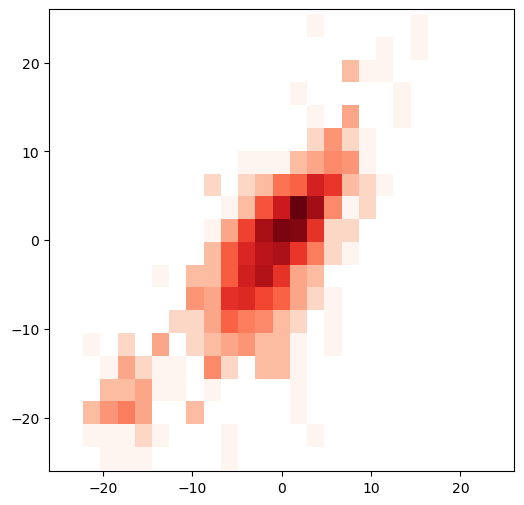

In [11]:
import matplotlib as mpl
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)

ax.hist2d(data.rot_main, data.rot_mean/2, bins=20, cmap='Reds', norm=mpl.colors.LogNorm());
ax.set_xlim(-26, 26)
ax.set_ylim(-26, 26)

# Score HAMP sequences

### Get HAMP sequences

In [12]:
msa = SeqIO.parse(os.path.join(DATA_DIR, 'PF00672.alignment.full'), 'stockholm')

res = []
for s in msa:
    n_helix = str(s.seq[35:52])
    c_helix = str(s.seq[154:169])

    # uniprot MSA
    #n_helix = str(s.seq[8:50]).replace('-','')
    #c_helix = str(s.seq[183:216]).replace('-','') 
    
    n_helix_degap = n_helix.replace('-','')
    c_helix_degap = c_helix.replace('-','')
    
    if len(n_helix_degap) == len(c_helix_degap) == 13:
        res.append([n_helix_degap, c_helix_degap, s.description])
    #else:
        #print(n_helix, '   ', c_helix)
        #break
len(res)      

71152

In [13]:
data_df = pd.DataFrame(res, columns=['n_seq', 'c_seq', 'desc'])
data_df['n_seq'] = data_df['n_seq'].apply(lambda x:x[1:-1])
data_df['c_seq'] = data_df['c_seq'].apply(lambda x:x[1:-1])
assert all(data_df['n_seq'].str.len() == 11)
assert all(data_df['c_seq'].str.len() == 11)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering
data_df.drop_duplicates(subset = 'sequence', inplace=True)
data_df.drop(data_df[data_df.sequence.str.find('X')>-1].index, inplace=True)
len(data_df)

59456

### Score with the main model

In [14]:
#score with the main model 
res_pred = clf_main.predict(data_df.sequence.tolist())

59/59 [==============================] - 22s 341ms/step


In [14]:
data_df['rot_main'] = res_pred.N_pred.apply(lambda x:np.mean(x)/2).tolist()

In [15]:
data_df.to_pickle(os.path.join(DATA_DIR, 'scan.p'))

### Set-up

In [16]:
clusterTool = mmseqs2.MMSeqsClusterer()

In [17]:
data_df = pd.read_pickle(os.path.join(DATA_DIR, 'scan.p'))
len(data_df)

59456

### Analyses

In [18]:

data_df = clusterTool.cluster(data_df, min_identity=0.8, coverage=0.5,
                   cov_mode=0, cluster_mode=1)

createdb /tmp/zap4raji tmp/223488683650315352/input --max-seq-len 65535 --dont-split-seq-by-len 1 --dbtype 0 --dont-shuffle 1 --id-offset 0 --compressed 0 -v 3 

Converting sequences
[=====
Time for merging files: 0h 0m 0s 36ms
Time for merging files: 0h 0m 0s 34ms
Time for merging files: 0h 0m 0s 5ms
Time for processing: 0h 0m 0s 264ms
cluster tmp/223488683650315352/input tmp/223488683650315352/clu tmp/223488683650315352/clu_tmp -c 0.5 --cov-mode 0 --min-seq-id 0.8 --cluster-mode 1 

Tmp tmp/223488683650315352/clu_tmp folder does not exist or is not a directory.
Created dir tmp/223488683650315352/clu_tmp
Set cluster settings automatically to s=1.000000
connected component clustering produces less clusters in a single step clustering.
Please use --single-step-clusterkmermatcher tmp/223488683650315352/input tmp/223488683650315352/clu_tmp/13318678693570626437/linclust/5072229819754896994/pref --sub-mat blosum62.out --alph-size 13 --min-seq-id 0.8 --kmer-per-seq 21 --adjust-kmer-len 0 --m

prefilter tmp/223488683650315352/clu_tmp/13318678693570626437/input_step_redundancy tmp/223488683650315352/clu_tmp/13318678693570626437/input_step_redundancy tmp/223488683650315352/clu_tmp/13318678693570626437/pref_step0 --sub-mat blosum62.out --seed-sub-mat VTML80.out -s 1 -k 0 --k-score 2147483647 --alph-size 21 --max-seq-len 65535 --max-seqs 20 --split 0 --split-mode 2 --split-memory-limit 0 -c 0.5 --cov-mode 0 --comp-bias-corr 0 --diag-score 0 --exact-kmer-matching 0 --mask 1 --mask-lower-case 0 --min-ungapped-score 0 --add-self-matches 0 --spaced-kmer-mode 1 --db-load-mode 0 --pca 1 --pcb 1.5 --threads 20 --compressed 0 -v 3 

Using 20 threads.
Estimated memory consumption 1020 MB
Target database size: 40317 type: Aminoacid
Query database size: 40317 type: Aminoacid
Process prefiltering step 1 of 1

Index table k-mer threshold: 154 at k-mer size 6 
Index table: counting k-mers
[=================================================================] 40.32K 0s 30ms
Index table: Masked re

In [19]:
def compare_sequences(seq1, seq2, method=""):
    spacer = '.' * 3
    #print('IIELSNTADKI   IGILAKSIERL')
    print('x  da  x  d'+(" "*len(spacer))+'a  x  da  x ')
    print(f'{seq1.n_seq}{spacer}{seq1.c_seq} {np.round(seq1["rot_main"],1)} {seq1.desc}')
    r=""
    c=0
    for i,j in zip(list(seq1.n_seq+spacer+seq1.c_seq), list(seq2.n_seq+spacer+seq2.c_seq)):
        if i==j and i!=spacer[0]:
            r+='|'
        else:
            r+=' '
    print(r)
    print(f'{seq2.n_seq}{spacer}{seq2.c_seq} {np.round(seq2["rot_main"],1)} {seq2.desc}')

In [20]:
def max_ident(sequences):
    m = [0, 0, 0]
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            if i>j:
                ident = (sequence_identity(sequences[i], sequences[j]))
                if ident>m[0]:
                    
                    # check if the difference is only in the core positions
                    
                    #       IIELSNTADKIIGILAKSIERL
                    #       x  da  x  da  x  da  x
                    mask = "*  **  *  **  *  **  *"
                    
                    OK=True
                    for aa1, aa2, aam in zip(list(sequences[i]), list(sequences[j]), list(mask)):
                        if aa1!=aa2 and aam!='*':
                            OK=False
                            break
                            
                            
                    if OK:
                        m = [ident, i, j]                
    return m

In [21]:
def all_ident(sequences):
    res = []
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            if i>j:
                # check if the difference is only in the core positions
                
                #       a  x  da  x   x  da  x  d    
                #       EAGLAEMSRQH   AARIAKGVNEL
                #       IIELSNTADKI   IGILAKSIERL
                #       x  da  x  d   a  x  da  x
                mask = "*  **  *  *"+"*  *  **  *"

                OK=True
                mut_pos = []
                for aa1, aa2, aam, pos in zip(list(sequences[i]), 
                                              list(sequences[j]), 
                                              list(mask), 
                                              range(len(mask))):
                    
                    # we look for mutations only in the defined core positions (mask)
                    if aa1!=aa2:
                        if aam!='*':
                            OK=False
                            break
                        else:
                            mut_pos.append(pos)


                if OK:
                    ident = (sequence_identity(sequences[i], sequences[j]))
                    res.append([ident, i, j, mut_pos])
    return res

In [22]:
def compare_similar(method, MIN_CLUST_SIZE=2, mark_clusters = []):

    res = []

    for clust_id, g in (data_df.groupby('clust_id')):
        size = len(g)
        if size<MIN_CLUST_SIZE: continue

        # all-vs-all seq ident
        for seq_diff, i, j, mut_pos in all_ident(g.sequence.tolist()):
            if len(mut_pos) != 1: continue
            mut_pos_new = mut_pos[0]

            # gather data
            rot_min = g.iloc[i][f'rot_{method}'] 
            rot_max = g.iloc[j][f'rot_{method}']

            newi, newj = i,j
            if rot_min>rot_max:
                newi = j
                newj = i

            rot_diff = abs(rot_max - rot_min)
            rot_min_row = g.iloc[newi]
            rot_max_row = g.iloc[newj]  
            rot_min_desc = rot_min_row.desc.split('/')[0]
            rot_max_desc = rot_max_row.desc.split('/')[0]
            
            if clust_id in mark_clusters: 
                color = 'red'
            else:
                color = 'grey'

            res.append([clust_id, seq_diff, rot_diff, rot_min, rot_max, rot_min_row.name, rot_max_row.name, color])

    res_df = pd.DataFrame(res, columns=['clust_id', 'seq_diff', 'rot_diff', 'rot_min', 'rot_max', 
                                       'row_min_id', 'row_max_id', 'color'])
    
    
    res_df['row_min_desc'] = res_df['row_min_id'].apply(lambda x:data_df.loc[x].desc.split('/')[0])
    res_df['row_max_desc'] = res_df['row_max_id'].apply(lambda x:data_df.loc[x].desc.split('/')[0])
    
    return res_df

In [28]:
def plot_res(res_df, m_n="", bar_pos=0.98):
    title_font_size = 10
    label_font_size = 10
    tick_font_size = 8

    fig, ax = plt.subplots(1,1, figsize=(3, 7), dpi=200)
    ax.axhline(y=res_df.rot_diff.quantile(bar_pos), color='red', linestyle='--', lw=0.75)
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)

    ax.set_xlabel('', size=label_font_size)
    ax.set_ylabel(r'Absolute difference in predicted rotation [$\degree$]', size=label_font_size)
    ax.set_title("Effects of point mutations", size=title_font_size)

    sns.swarmplot(res_df, y='rot_diff', ax=ax, s=2, c=res_df.color)

    ax.set_xticks([]) 

In [41]:
mark_cluster = []
res_df_main = compare_similar(method='main', mark_clusters = mark_cluster)


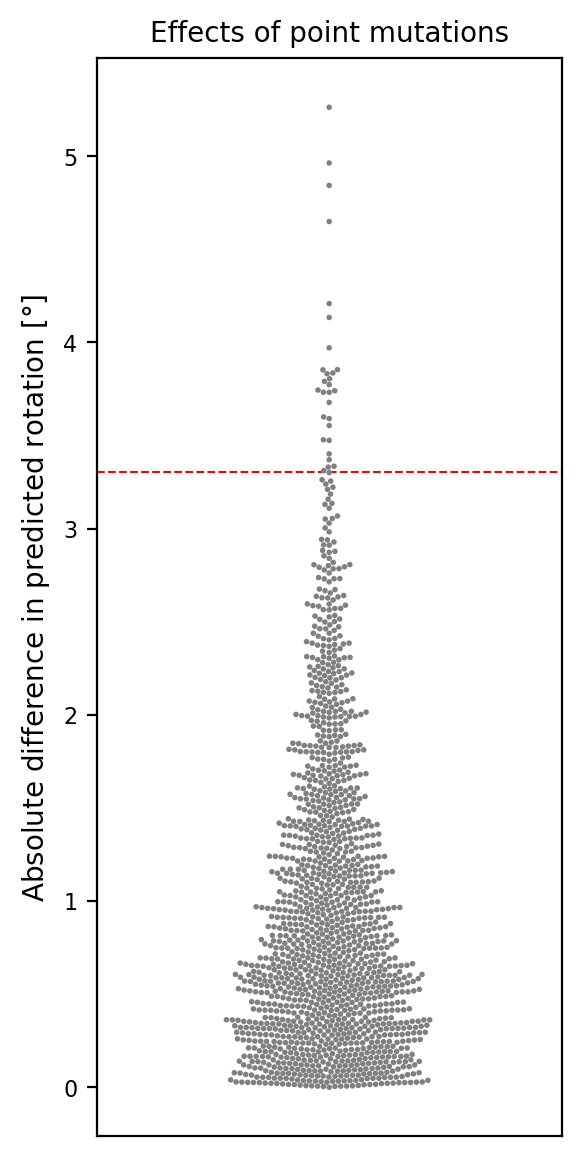

In [44]:
plot_res(res_df_main, bar_pos=0.98)

In [ ]:
TOP = int(len(res_df_main)* 0.02)

for g_name, g in res_df_main.sort_values(by='rot_diff', ascending=False).head(TOP).groupby('clust_id'):

    print(str(g_name) + " " + '-'*50)
    
    for idx in g.index:
        pair = g.loc[idx]
        rot_min_row = data_df.loc[pair.row_min_id]
        rot_max_row = data_df.loc[pair.row_max_id]
        compare_sequences(rot_min_row, rot_max_row, 'main')

        rot_min_desc = rot_min_row.desc.split('/')[0]
        rot_max_desc = rot_max_row.desc.split('/')[0]  
        print()
        print(rot_min_desc, rot_max_desc)
        print()


### Analyse poly-HAMPs

In [36]:
ids = [ seq.id.split('_')[1] for seq in SeqIO.parse('/home/nfs/morlowska/HAMP/plecha_nr/HAMP/first_HAMP_ready_num_renamed.fst', 'fasta') ]

for i in set(ids):
    if i.find('|')>-1: continue
    print(i)

# map with UniProt to UniProt IDs

PYX32209.1
PVZ04703.1
AHM63257.1
KZB82898.1
OXM47601.1
PZV96211.1
PWC94807.1
PZN69162.1
PJZ31095.1
QER85793.1
AXA90328.1
QDZ28531.1
PYS18698.1
PJZ57733.1
OYV76641.1
OLZ46002.1
OAV48710.1
PNV32409.1
AYG80044.1
QDE86919.1
OKJ08435.1
GAX40976.1
BAC88576.1
PCC69385.1
ALU96599.1
QHS64032.1
OXM43487.1
PYJ57525.1
AGM04529.1
GAP48851.1
PYU97090.1
QWA24468.1
PDT02807.1
QLE58993.1
EME52012.1
QKW09535.1
AGY58915.1
AZM51025.1
OJH41560.1
POX52225.1
OWU92479.1
TXS06642.1
AKF79476.1
APX88525.1
TXJ23595.1
TWJ24605.1
ADL43896.1
PTY01147.1
CAC9974298.1
AMY12078.1
PZR27878.1
ADJ23177.1
OLZ45288.1
ABF86070.1
ELS57048.1
OCX52005.1
PYR68252.1
CCD02174.1
BCA54573.1
OXM63166.1
BDA75023.1
BBH65628.1
AKJ05961.1
ALG73158.1
ABK32300.1
AVH67450.1
OKH16128.1
AMV20836.1
OYD83186.1
ANW01392.1
AUI57076.1
KUN41687.1
OXM51161.1
PWC40026.1
PWC60148.1
OJW55147.1
OLO30478.1
BBO33313.1
PWR06051.1
PZH15584.1
GAQ63868.1
AYL40104.1
TXE24974.1
ODH03206.1
OKI54352.1
PYS56188.1
RDY65438.1
AWL85723.1
PWC89754.1
QKZ21629.1
BCJ27670

In [37]:
# read mappings
poly_idmap = pd.read_csv('./data/uniprot-download_true_fields_accession_2Cid_format_tsv-2023.03.21-09.41.00.25.tsv',
                        sep='\t')

poly_idmap.set_index('Entry Name', inplace=True)

In [48]:
poly_idmap.loc['A0A563EXG1_9PSEU']

KeyError: 'A0A563EXG1_9PSEU'

In [223]:
# res_df_aux[
#     (res_df_aux.row_min_desc.isin(poly_idmap.index)) & (res_df_aux.row_max_desc.isin(poly_idmap.index))
# ].sort_values(by='rot_diff', ascending=False)

In [224]:
#compare_sequences(data_df.loc[51172], data_df.loc[148], 'main')

In [225]:
# analyse poly-hamps (main method)
#res_df_main[res_df_main.color == 'red'].sort_values(by='rot_diff', ascending=False)

In [229]:
# analyse poly-hamps (aux method)
#res_df_aux[res_df_aux.color == 'red'].sort_values(by='rot_diff', ascending=False)

In [40]:
g

,clust_id,seq_diff,rot_diff,rot_min,rot_max,row_min_id,row_max_id
1437,69577,95.454545,4.28534,1.25122,5.53656,52401,10577


In [28]:
res_df_aux.loc[common]

,clust_id,seq_diff,rot_diff,rot_min,rot_max,row_min_id,row_max_id
232,552,95.454545,10.538080,-11.086540,-0.548460,32230,8148
137,552,95.454545,13.897576,-14.242147,-0.344571,14112,7025
207,552,95.454545,10.040075,-0.181607,-10.221682,1993,25792
208,552,95.454545,15.230750,-0.181607,-15.412357,11040,25792
94,552,95.454545,9.667584,-0.344571,-10.012154,148,7025


In [35]:
radius['F']

189.9

<AxesSubplot: >

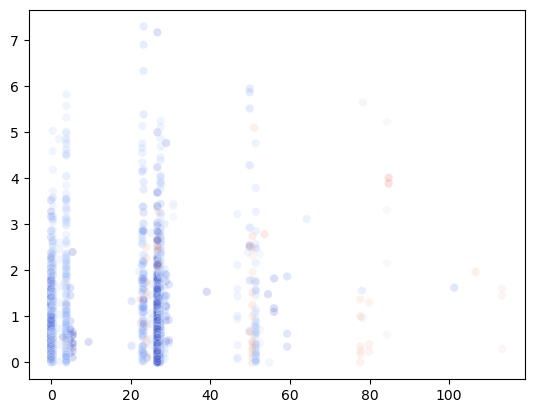

In [36]:
sns.scatterplot(x=profile_size_change, y=profile_rot_change, c=profile_phobos_change, alpha=0.2, cmap='coolwarm')

In [37]:
import matplotlib.cm as cm

tmp = res_df.color.unique()
    
# i:cm.tab20c(pos)
palette={i:'red' if i in [18] else 'cyan' for pos, i in enumerate(tmp)}
palette

{17: 'cyan',
 4: 'cyan',
 14: 'cyan',
 0: 'cyan',
 11: 'cyan',
 7: 'cyan',
 3: 'cyan',
 10: 'cyan',
 21: 'cyan',
 18: 'red'}

In [61]:

ax.scatter(res_df['seq_diff'], res_df['rot_diff'], s=2, alpha=1)
ax.set_title('HAMP (PF00672)', size=17)
ax.set_ylabel('Predicted conformation variability (degrees)', size=13)
ax.set_xlabel('Mean sequence identity (%)', size=13)

Text(0.5, 8.888888888888882, 'Mean sequence identity (%)')

In [ ]:
# compare neutral to changing substitutions!
# color by function!

In [16]:
# def calculate_variability_index(values):
#     max_val = max(values)
#     min_val = min(values)
#     return (max_val - min_val) / (max_val + min_val)

# import statistics

# def calculate_variability_index2(values):
#     mean_val = statistics.mean(values)
#     stdev_val = statistics.stdev(values)
#     return stdev_val / mean_val


# import statistics

# def calculate_mad(values):
#     median_val = statistics.median(values)
#     deviations = [abs(x - median_val) for x in values]
#     mad_val = statistics.median(deviations)
#     return mad_val

# import statistics

# def calculate_iqr(values):
#     q1 = statistics.median(values[:len(values)//2])
#     q3 = statistics.median(values[(len(values)+1)//2:])
#     iqr_val = q3 - q1
#     return iqr_val

In [220]:
method = 'main'

res = []

for clust_id, g in tqdm(data_df.groupby('clust_id')):
    size = len(g)
    if size!=2: continue

    

    break
    
    # descriptors
    g_cons = np.mean(
        msa_diversity(g.sequence.tolist())
    )
                
    g_rot = g['rot_'+method].std() 
    #g_rot = calculate_mad(g['rot_'+method])
    
    #colors
    (name_color, name_color_freq), (go_color, go_color_freq) = group2color(g)
    
    if go_color=='transcription_regulation':
        color = 'red'
    elif go_color=='chemotaxis':
        color = 'green'
    else:
        color='lightgrey'

            
    #if color_freq < 0.25 or color=='x': continue
       
    # ['transcription_regulation', 'chemotaxis', 'cyclic_nucleotide_biosynthesis', 
    # 'signal_transduction_regulation', 'nitrogen_fixation', 'response_to_stress', 
    # 'osmosensory_signaling', 'transmembrane_transport']
      
        
    res.append(
        (g_cons, g_rot, color)
    )
    
    if g_rot>4:
        print((name_color, name_color_freq), (go_color, go_color_freq), (g_cons, g_rot))
        print(g)
        print()
        #break



  0%|                                                                                                                 | 20/30437 [00:00<00:16, 1794.74it/s]


In [214]:
res_df = pd.DataFrame(res, columns=['conservation', 'rotation', 'color'])
len(res_df)

2574

Text(0.5, 0, 'Mean sequence identity (%)')

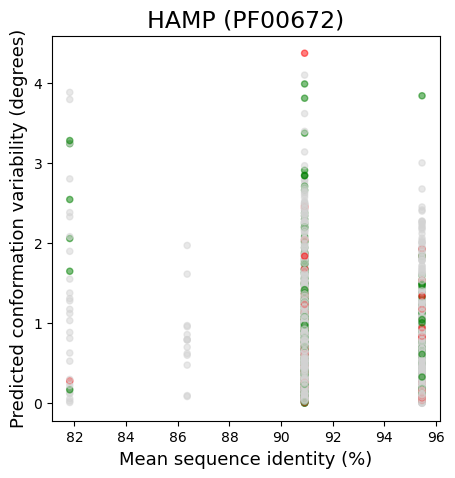

In [215]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=100)
ax.scatter(res_df['conservation'], res_df['rotation'], c=res_df['color'], s=20, alpha=0.5)
ax.set_title('HAMP (PF00672)', size=17)
ax.set_ylabel('Predicted conformation variability (degrees)', size=13)
ax.set_xlabel('Mean sequence identity (%)', size=13)

In [18]:
# def list_to_freq_dict(lst, s):
#     freq_dict = {}
#     a = 1 / s
#     #print(len(lst))
#     for element in lst:
#         if element in freq_dict:
#             freq_dict[element] += a
#         else:
#             freq_dict[element] = a
#     return freq_dict

# def scan_cluster(g):
#     go = []
#     for sid, srow in g.iterrows():
#         try:
#             uni_desc = uni_df.loc[srow.desc.split('/')[0]]
#             go.extend(
#                 uni_desc['Gene Ontology (biological process)'].split('; ')
#             )
#         except KeyError:
#             pass
#         except AttributeError:
#             pass
#     return list_to_freq_dict(go, len(g))

In [19]:
# from Bio.SubsMat import MatrixInfo


# def conservation_index_blosum(sequences):
#     """
#     Calculates the per-column conservation index for a list of protein sequences.
    
#     Args:
#         sequences (list): A list of protein sequences.
        
#     Returns:
#         cons_index (list): A list of conservation scores for each column of the MSA.
#     """
#     # Load the BLOSUM62 substitution matrix
#     blosum62 = MatrixInfo.blosum62

#     # Dictionary to store the frequency of each amino acid at each position in the MSA
#     aa_freq = {}

#     # Calculate the frequency of each amino acid at each position
#     for sequence in sequences:
#         for i, aa in enumerate(sequence):
#             if i not in aa_freq:
#                 aa_freq[i] = {}
#             if aa not in aa_freq[i]:
#                 aa_freq[i][aa] = 0
#             aa_freq[i][aa] += 1

#     # Calculate the conservation score for each column
#     cons_index = []
#     for i in range(len(aa_freq)):
#         col_scores = []
#         for aa1 in aa_freq[i]:
#             for aa2 in aa_freq[i]:
#                 if aa1 != aa2:
#                     score = blosum62.get((aa1, aa2), blosum62.get((aa2, aa1), -4))
#                     col_scores.append(score * aa_freq[i][aa1] * aa_freq[i][aa2])
#         if not col_scores:
#             cons_index.append(0)
#         else:
#             cons_index.append(sum(col_scores) / (sum(aa_freq[i].values()) ** 2))

#     return cons_index


In [20]:
# def conservation_index(sequences):
#     """
#     Reads a protein MSA from a file in FASTA format and calculates the per-column conservation index.
    
#     Args:
#         fasta_file (str): Path to the FASTA file containing the protein MSA.
        
#     Returns:
#         cons_index (list): A list of conservation scores for each column of the MSA.
#     """
#     # Dictionary to store the frequency of each amino acid at each position in the MSA
#     aa_freq = {}

#     # Calculate the frequency of each amino acid at each position
#     for sequence in sequences:
#         for i, aa in enumerate(sequence):
#             if i not in aa_freq:
#                 aa_freq[i] = {}
#             if aa not in aa_freq[i]:
#                 aa_freq[i][aa] = 0
#             aa_freq[i][aa] += 1

#     # Calculate the conservation score for each column
#     cons_index = []
#     for i in range(len(aa_freq)):
#         total_aa = sum(aa_freq[i].values())
#         if total_aa == 0:
#             cons_index.append(0)
#         else:
#             max_freq = max(aa_freq[i].values())
#             cons_index.append(max_freq / total_aa)

#     return cons_index


In [21]:
# def group2fasta(g, fname):
#     with open(fname, 'wt') as f:    
#         for i, g in g.iterrows():
#             f.write(f'>{i}\n{g.sequence}\n')
        
# def most_frequent_string(strings):
#     string_counts = Counter(strings)
#     most_common_string, frequency = string_counts.most_common(1)[0]
#     return most_common_string, frequency / len(strings)


### all-vs-all in clusters approach

In [638]:
def compare_dataframe_rows(df, sequence_column):
    n = len(df)
    similarities = []
    for i in range(n):
        for j in range(i+1, n):
            row1 = df.iloc[i]
            row2 = df.iloc[j]
            seq_similarity = sequence_identity(row1[sequence_column], row2[sequence_column])
            rot_diff_main = abs(row1['rot_main'] - row2['rot_main'])
            rot_diff_aux = abs(row1['rot_aux'] - row2['rot_aux'])
            similarities.append((row1.desc.split('/')[0], row2.desc.split('/')[0], seq_similarity, rot_diff_main, 
                                 rot_diff_aux, row1.name, row2.name))
    return similarities

res_list=[]

# iterate over groups defined by mmseqs2
for i, g in tqdm(data_df.groupby('clust_id')):
    if len(g)<MIN_CLU_SIZE: continue
        
    if len(g)>50: continue
    
    # in each group compare all the sequences all-vs-all
    res = compare_dataframe_rows(g, 'sequence')
    
    
    
    # i,j are protein ids and i_idx, j_idx are indexes in data_df
    res_df = pd.DataFrame(res, columns=['i', 'j', 'seq_sim', 'rot_diff_main', "rot_diff_aux", "i_idx", 'j_idx'])
    res_df['cluster'] = i
    res_list.append(res_df)
    
res_df = pd.concat(res_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30437/30437 [00:18<00:00, 1604.66it/s]


In [645]:
method = 'main'
count=0
X,Y, C=[],[],[]
for clust_id, g in data_df.groupby('clust_id'):
    size = len(g)
    if size<5 or size>50: continue
        
    count+=1
    continue
        
    g_res = res_df[res_df.cluster==clust_id]
    
    # full msa conservation vs hamp conservation
    #( clustalo)
    
    # pair with the max predicted rot difference 
    rot_max_row = g_res.iloc[g_res['rot_diff_'+method].argmax()]
    rm_seq_sim = rot_max_row.seq_sim
    rm_rot = rot_max_row['rot_diff_'+method]
    
    # whole cluster
    seq_sim_mean = g_res.seq_sim.mean()
    rot_diff_mean = g_res['rot_diff_'+method].mean()
    
    # set color
    
    sc = scan_cluster(g)
    
    if len(sc)==0:
        continue
    else: 
        q = 'regulation of DNA-templated transcription [GO:0006355]' in sc.keys()
        p = 'chemotaxis [GO:0006935]' in sc.keys()
        
        if p and not q:
            color = 'red'
        elif q and not p:
            color='blue'
        else:
            color='grey'
            #print(sc)
            continue
  
    # show model proteins
    #if clust_id in cluster2desc.keys():
    #    color='red'
    #else:
    #    color='lightgrey'

    Y.append(seq_sim_mean)
    X.append(rm_rot)
    C.append(color)
    
    if rot_diff_mean > 7 and seq_sim_mean > 70 and seq_sim_mean < 75:
        print(" ".join([p.split('/')[0] for p in g.desc.tolist()]))
        print("")
        print(g)
        print()
        
print(len(X))

0


In [646]:
count

1095

/tmp/ipykernel_32185/2380154057.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, c=C, s=20, cmap='coolwarm', alpha=0.5)


Text(0, 0.5, 'Mean sequence identity (%)')

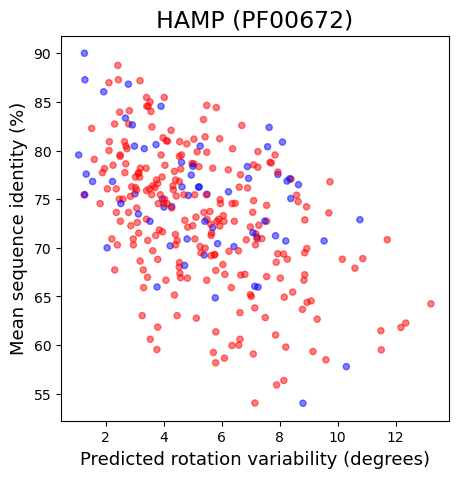

In [640]:
fig, ax = plt.subplots(1,1, figsize=(5, 5), dpi=100)

ax.scatter(X, Y, c=C, s=20, cmap='coolwarm', alpha=0.5)
ax.set_title('HAMP (PF00672)', size=17)
ax.set_xlabel('Predicted rotation variability (degrees)', size=13)
ax.set_ylabel('Mean sequence identity (%)', size=13)

In [123]:
C.count('red')

242

In [125]:
C.count('blue')

64

In [ ]:
#         for rowid, row in g.iterrows():
#             ident = row.desc.split('/')[0]
#             print(ident)
#             if ident == 'Q9KL26_VIBCH':
#                 #print(row.sequence, np.round(row['rot_'+method],1), row.desc)
#                 #print(seq_sim_mean, rot_diff_mean)
#                 pass
                
        
#         #print(f'rot: {np.round(rm_rot, 1)}, sim: {np.round(rm_seq_sim, 1)}')
    
#         #compare_sequences(data_df.loc[rot_max_row.i_idx], data_df.loc[rot_max_row.j_idx],
#         #                 method=method)
        
#         #for rowid, row in g.iterrows():
#         #    if rowid in [rot_max_row.i_idx, rot_max_row.j_idx]: continue     
#         #    print(row.sequence, np.round(row['rot_'+method],1), row.desc)
        
#         #print()
#         #print(sc)

In [ ]:
# Tar/Tsr - where? comp of chimeras

In [ ]:
# chemoreceptors domain composition mapping

In [ ]:
# compare taxonomy

In [ ]:
# Vibrio cholerae, the etiological agent of cholera, was found to be attracted by 
taurine (2-aminoethanesulfonic acid), a major constituent of human bile. Mlp37, the closest homolog of the previously identified amino acid chemoreceptor Mlp24


In [182]:
from itertools import chain

In [185]:
list_to_freq_dict(list(chain(*uni_df['Gene Ontology (biological process)'].apply(lambda x:x.split('; ') if not pd.isna(x) else '').tolist())), 1)

{'chemotaxis [GO:0006935]': 9794.0,
 'signal transduction [GO:0007165]': 19591.0,
 'cyclic nucleotide biosynthetic process [GO:0009190]': 932.0,
 'intracellular signal transduction [GO:0035556]': 903.0,
 'regulation of DNA-templated transcription [GO:0006355]': 2045.0,
 'phosphorylation [GO:0016310]': 588.0,
 'regulation of intracellular signal transduction [GO:1902531]': 857.0,
 'protein phosphorylation [GO:0006468]': 51.0,
 'osmosensory signaling via phosphorelay pathway [GO:0007234]': 20.0,
 'protein autophosphorylation [GO:0046777]': 285.0,
 'phosphorelay signal transduction system [GO:0000160]': 82.0,
 'nitrogen fixation [GO:0009399]': 103.0,
 'protein refolding [GO:0042026]': 1.0,
 'phosphate ion transport [GO:0006817]': 18.0,
 'cell adhesion involved in single-species biofilm formation [GO:0043709]': 3.0,
 'negative regulation of bacterial-type flagellum-dependent cell motility [GO:1902201]': 3.0,
 'organic substance transport [GO:0071702]': 2.0,
 'transmembrane transport [GO:00

In [78]:
16/22

0.7272727272727273

In [354]:

# def run_al2co(sequences):
#     with open('./data/tmp/temp.aln', 'wt') as f:    
#         for s in sequences:
#             f.write('Sequence  '+s+'\n')
#     os.system('~/apps/al2co/al2co -i ./data/tmp/temp.aln -o ./data/tmp/temp.cons -f 2')
    
#     cons = []
#     with open('./data/tmp/temp.cons', 'rt') as f:
#         while True:
#             l = f.readline()
#             if l[0] == '*': break
#             cons.append(float(l.strip().split(' ')[-1]))
#     assert len(cons) == 22
    
#     return np.mean(cons)
    
      


In [355]:
def group2color(g):
    colors=[]
    func_arr = []
    for i, seq in g.iterrows():
        ident = seq.desc.split('/')[0]
        try:
            func = protein2function_df[protein2function_df.index == ident]
            assert len(func)<2
            if len(func)==0: raise KeyError
            func = func.iloc[0].values
        except KeyError:
            pass
            #func_arr.append(np.array(['UNK', 'UNK'], dtype=object))
        else:
            func_arr.append(func)
    a = np.array(func_arr)
    if len(a)>0:
        return most_frequent_string(a[:,0]), most_frequent_string(a[:,1])
    else:
        return ('UNK', 1.0), ('UNK', 1.0)
        


In [122]:
tmp_df = pd.DataFrame(zip(X,Y,C), columns=['rot', 'seq', 'color'])

In [233]:
C=[]
for _, row in tqdm(res_df.iterrows()):
    try:
        i_desc = uni_df.loc[row.i]['Gene Ontology (biological process)']
        j_desc = uni_df.loc[row.j]['Gene Ontology (biological process)']
        
        if pd.isna(i_desc)or pd.isna(j_desc):
            raise KeyError
        
    except KeyError:
        C.append('white')
        continue
    
    if i_desc.find('chemotaxis') and j_desc.find('chemotaxis'):
        C.append('red')
    else:
        C.append('yellow')
    

37598it [00:08, 4227.67it/s]


In [234]:
assert len(res_df) == len(C)
res_df['color'] = C

<AxesSubplot: xlabel='seq', ylabel='Count'>

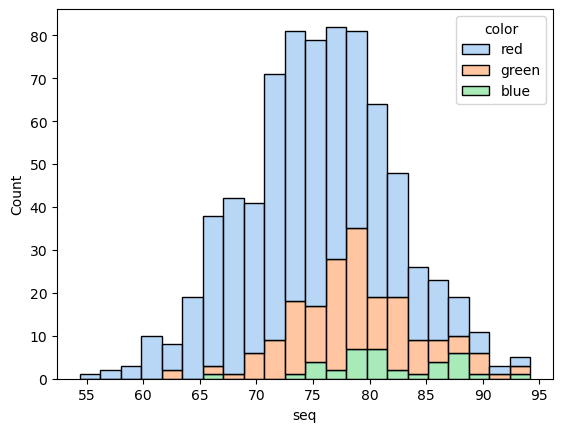

In [128]:
sns.histplot(data=tmp_df, stat="count", multiple="stack",
             x="seq", kde=False,
             palette="pastel", hue="color",
             element="bars", legend=True)


In [59]:
x=np.asarray(X)
c=np.asarray(C)

In [601]:
# map well-characterised proteins to mmseqs2 clusters

cluster2desc = {}

for ident, desc in [
    # E. coli
    ['A0A0H2V3U6_SHIFL/214-265', 'Tsr'],
    ['A0A0H2V3U6_SHIFL/214-265', 'Tar'],
    ['A0A0H2VWT4_SHIFL/221-272', 'Trg'],
    ['MCP4_ECOLI/209-261', 'Tap'],
    ['A0A0J8Y5H1_9ENTR/177-229', 'EnvZ'],
    
    # B. subtilis
    #['MCPA_BACSU/300-352', 'McpA'],
    #['MCPB_BACSU/301-353', 'McpB'],
    #['MCPC_BACSU/295-347', 'McpC']
    
]:
    tmp = data_df[data_df.desc==ident]
    if len(tmp)==0:
        print(desc, 'not found')
        continue
    cluster = tmp.iloc[0].clust_id
    g = data_df[data_df.clust_id==cluster]
    cluster_size = len(g)
    
    if cluster_size<MIN_CLU_SIZE:
        print(desc, 'cluster too small', cluster_size)
        print(g)
        continue
        
    if cluster in cluster2desc:
        cluster2desc[cluster].append(desc)
    else:
        cluster2desc[cluster] = [desc]
    
cluster2desc  

{49578: ['Tsr', 'Tar'], 5089: ['Trg'], 42689: ['Tap'], 31177: ['EnvZ']}

<AxesSubplot: ylabel='Count'>

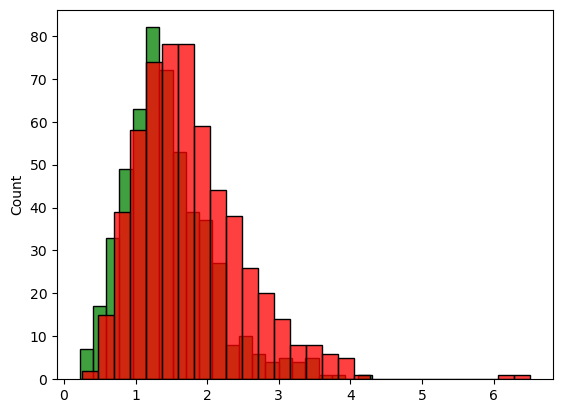

In [60]:
sns.histplot(x[c=='green'], color='green')
sns.histplot(x[c=='red'], color='red')

In [18]:
import seaborn as sns

In [274]:
#sns.kdeplot(data=geyser, x="waiting", y="duration", hue="kind")

In [190]:
#uni_df#['Protein names'].value_counts()[:10]

In [52]:
res = []
for i, g in data_df.groupby('clust_id'):
    if len(g)!=2: continue
    
    sc = scan_cluster(g)
    
    if len(sc)==0:
        continue
    else:    
        if 'chemotaxis [GO:0006935]' in sc.keys():
            t='chemo'
        elif 'regulation of DNA-templated transcription [GO:0006355]' in sc.keys():
            t='hist'
        else:
            t='other'
    res.append((i, g.rot_aux.min()-g.rot_aux.max(), t))
    #break

In [53]:
res_df = pd.DataFrame(res, columns=['clust_id', 'rot_main_max_diff', 'type'])
len(res_df)

4

In [54]:
res_df.sort_values(by='rot_main_max_diff', ascending=True)

,clust_id,rot_main_max_diff,type
2,31055,-6.260744,hist
1,6374,-3.893756,other
0,2707,-1.265798,other
3,53859,-0.907727,other


<AxesSubplot: xlabel='type', ylabel='rot_main_max_diff'>

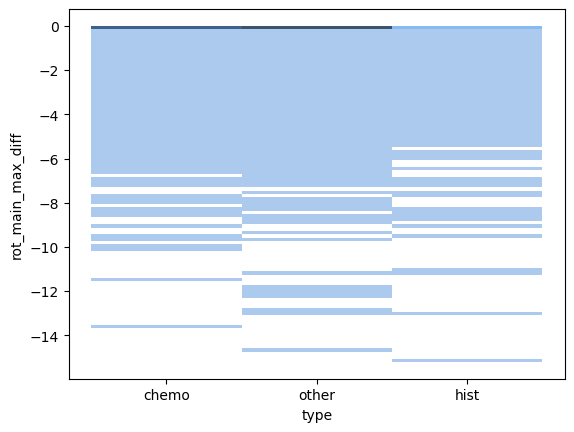

In [50]:
sns.histplot(data=res_df, y='rot_main_max_diff', x='type', bins=100)

In [38]:
tmp=data_df[data_df.clust_id==722]

In [39]:
compare_sequences(tmp.iloc[0], tmp.iloc[1], 'main')

NameError: name 'compare_sequences' is not defined

In [137]:
uni_df.loc['A0A5J6SI04_9BACI']

Entry                                                                        A0A5J6SI04
Entry Name                                                             A0A5J6SI04_9BACI
Protein names                                            histidine kinase (EC 2.7.13.3)
Gene Names                                                                   PB01_00560
Organism                                                        Psychrobacillus glaciei
Length                                                                              459
Gene Ontology (biological process)                                                  NaN
Gene Ontology (GO)                    membrane [GO:0016020]; ATP binding [GO:0005524...
Repeat                                                                              NaN
Taxonomic lineage                     Psychrobacillus (genus), Bacillaceae (family),...
Pathway                                                                             NaN
Name: A0A5J6SI04_9BACI, dtype: o

# Importance

In [31]:
import itertools

In [242]:
m = '***********' + '***********'
s = 'IIELSNTADKI' + 'IGILAKSIERL'
m_pos = [n for n,i in enumerate(list(m)) if i=='*']
#m_pos, len(m_pos)

In [243]:
aas = ['V', 'I', 'L', 'M', 'F', 'A']

def mutate(seq, pos, N):
    for n in range(1,N+1):
        for muts in itertools.combinations(pos, n):
            combs = list(itertools.product(
                *[list(itertools.product([mut], aas)) for mut in muts]
            ))
            
            for comb in combs:
                new_seq = seq[:]
                for p, aa in comb:
                    if new_seq[p] == aa: break
                    new_seq = new_seq[:p] + aa + new_seq[p+1:]
                else: 
                    yield (new_seq, comb)

            
                

In [250]:
imp = []
imp.append(('IIELSNTADKI', 'IGILAKSIERL', -1, 'IIELSNTADKIIGILAKSIERL'))

for seq, comb in mutate(s, m_pos, 1):
    n = seq[:11]
    c = seq[11:]
    imp.append((n, c, comb[0][0], n+c))
    
    
imp_df = pd.DataFrame(imp, columns=['n_seq', 'c_seq', 'comb', 'sequence'])

In [251]:
imp_df['pred'] = clf_aux.predict(encode_df(imp_df)).mean(axis=1) / 2

#imp_df['pred']= clf_main.predict(imp_df.sequence.tolist()).N_pred.apply(lambda x:np.mean(x)/2).tolist()

In [252]:
imp_df['diff'] = abs(imp_df['pred'] - imp_df.iloc[0].pred)

In [253]:
#imp_df['diff'].plot.hist(bins=30)
imp_df.groupby('comb')['diff'].mean()

comb
-1     0.000000
 0     1.315285
 1     0.475150
 2     4.661668
 3     2.458989
 4     3.954425
 5     0.674829
 6     3.487037
 7     2.736640
 8     6.824503
 9     1.329492
 10    1.268235
 11    0.580340
 12    6.744746
 13    1.681028
 14    2.151079
 15    6.346503
 16    4.249150
 17    5.541609
 18    4.197907
 19    6.724906
 20    4.066050
 21    4.451372
Name: diff, dtype: float64

<AxesSubplot: >

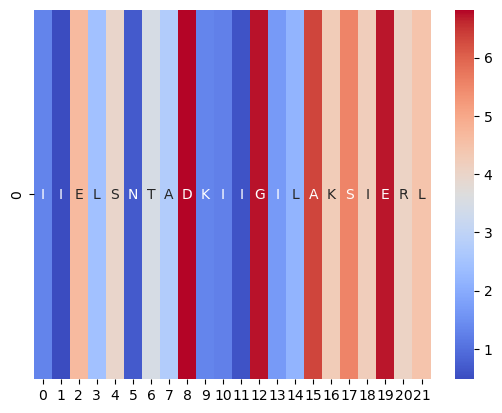

In [254]:
sns.heatmap(
imp_df.groupby('comb')['diff'].mean().values[1:].reshape(1,22),
    cmap='coolwarm',
    annot = np.asarray(list('IIELSNTADKIIGILAKSIERL')).reshape(1,22), fmt=""
)

In [258]:
method = 'aux'

profile_phobos_change = []
profile_size_change =[]
profile_rot_change = []

res = []

for clust_id, g in (data_df.groupby('clust_id')):
    size = len(g)
    if size<2: continue
        
    # max rot diff
#     rot_min_row = g.iloc[g[f'rot_{method}'].argmin()]
#     rot_max_row = g.iloc[g[f'rot_{method}'].argmax()]
#     rot_diff = rot_max_row[f'rot_{method}'] - rot_min_row[f'rot_{method}']
#     seq_diff = sequence_identity(rot_max_row.sequence, rot_min_row.sequence)   
        
    # max seq ident    
#     seq_diff, i, j = max_ident(g.sequence.tolist())
#     rot_diff = abs(g.iloc[i][f'rot_{method}'] - g.iloc[j][f'rot_{method}'])
#     rot_min_row = g.iloc[i]
#     rot_max_row = g.iloc[j]
    
    # all-vs-all seq ident
    for seq_diff, i, j, mut_pos in all_ident(g.sequence.tolist()):
        if len(mut_pos) != 1: continue
        mut_pos_new = mut_pos[0]
            
        # gather data
        rot_min = g.iloc[i][f'rot_{method}'] 
        rot_max = g.iloc[j][f'rot_{method}']
        
        newi, newj = i,j
        if rot_min>rot_max:
            #tmp = rot_max
            #rot_max = rot_min
            #rot_min = tmp
            newi = j
            newj = i
        
        rot_diff = abs(rot_max - rot_min)
        rot_min_row = g.iloc[newi]
        rot_max_row = g.iloc[newj]  
        rot_min_desc = rot_min_row.desc.split('/')[0]
        rot_max_desc = rot_max_row.desc.split('/')[0]
        
        # describe mutation type
#         aa1 = rot_min_row.sequence[mut_pos_new]
#         aa2 = rot_max_row.sequence[mut_pos_new]
#         phobos_diff = abs(phobos[aa2] - phobos[aa1])
#         size_diff = abs(radius[aa1] - radius[aa2])
        
#         profile_phobos_change.append(phobos_diff)
#         profile_size_change.append(size_diff)
#         profile_rot_change.append(rot_diff)

        #func_min = protein2function_df.loc[rot_min_desc]
        #func_max = protein2function_df.loc[rot_max_desc]
        
        color = mut_pos_new
                
        #if len(data_df[data_df.desc.str.startswith(rot_min_desc)])>1:
        #    color='red'
            
        res.append([clust_id, seq_diff, rot_diff, rot_min, rot_max, color, rot_min_row.name, rot_max_row.name])
        
#         if (rot_diff>=5 and method=='main') or (rot_diff>=9 and method=='aux'):
#             compare_sequences(rot_min_row, rot_max_row, method)
#             print(rot_min_desc, rot_max_desc, clust_id )
#             print(phobos_diff, aa1, aa2)
        
        
res_df = pd.DataFrame(res, columns=['clust_id', 'seq_diff', 'rot_diff', 'rot_min', 'rot_max', 'color', 
                                   'row_min_id', 'row_max_id'])
len(res_df)

KeyboardInterrupt: 